# **Mise en place des labels**

In [1]:
import os 
import geopandas
import geoplot
import geoplot.crs as gcrs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from zipfile import ZipFile

In [2]:
BASE_DIR = '../..'
DATA_DIR_RAW = os.path.join(BASE_DIR, "data/raw")
DATA_DIR_RAW

'../../data/raw'

## **Base Deir ez-Zor**

### **Importation des données**

*Attention : Supprimer le fichier temp avant de push dans le git (taille fu fichier trop élevée)*

In [3]:
zip_file = ZipFile(os.path.join(DATA_DIR_RAW, 'unitar_data/CE20130604SYR_Raqqa_Deir_shp.zip'))
zip_file.extractall(os.path.join(DATA_DIR_RAW, 'temp'))

data_ezzor = gpd.read_file(os.path.join(DATA_DIR_RAW, 'temp/Damage_Sites_Deir_ez_Zor_CDA.shp'))
data_ezzor.head(3)

,SiteID,SensDt,SensorID,ConfID,DaSitCl,SensorDate,SensID2,ConfID2,DaSitCl2,Damst2,...,ConfId5,DaSitCl5,Damst5,GrDaCl,FieldVl,Notes,Name,Neigh,Code,geometry
0,Building (General / Default),2013-10-24,Pleiades,Medium,Destroyed,2014-05-13,Pleiades,Medium,Destroyed,No change,...,Medium,Destroyed,No change,Damaged Buildings,Not yet field validated,None,Deir ez Zor,Al Jami Al Kabeer wa Al Wasat,CE20130604SYR,POINT (40.13379 35.34347)
1,Building (General / Default),2013-10-24,Pleiades,Medium,Destroyed,2014-05-13,Pleiades,Medium,Destroyed,No change,...,Medium,No Visible Damage,No change,Damaged Buildings,Not yet field validated,None,Deir ez Zor,Qosour,CE20130604SYR,POINT (40.13147 35.34176)
2,Building (General / Default),2013-10-24,Pleiades,Medium,Moderate Damage,2014-05-13,Pleiades,Medium,Moderate Damage,No change,...,Uncertain,Moderate Damage,No change,Damaged Buildings,Not yet field validated,None,Deir ez Zor,Qosour,CE20130604SYR,POINT (40.12980 35.34216)


Seules les dernières observations qui datent de 2017 sont gardées. 

In [4]:
data_ezzor = data_ezzor[['SiteID', 'SensDt5', 'SensId5', 'ConfId5', 'DaSitCl5',
                         'Damst5', 'GrDaCl', 'FieldVl', 'Neigh', 'Code', 'geometry']]

data_ezzor['DaSitCl5'].value_counts()

Moderate Damage                    2874
Severe Damage                      2370
Destroyed                          1161
Impact Crater (Damage to Field)     308
No Visible Damage                   236
Impact Crater (Damage to Road)       93
Name: DaSitCl5, dtype: int64

Nous filtrons les impactes de cratère pour ne garder que les observations concernant les bâtiments dans notre base.

In [7]:
data_ezzor = data_ezzor[data_ezzor['DaSitCl5'].isin(['Destroyed', 'Severe Damage', 'Moderate Damage', 'No Visible Damage'])]
data_ezzor['DaSitCl5'] = data_ezzor['DaSitCl5'].astype('category')
data_ezzor['DaSitCl5'] = data_ezzor['DaSitCl5'].cat.set_categories(['No Visible Damage', 'Moderate Damage', 'Destroyed', 'Severe Damage'], ordered=True)


Visualisation de nos données sur la carte de Deir ez-Zor

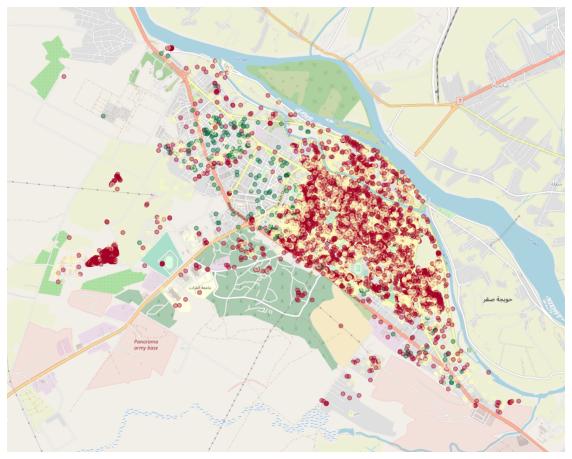

In [16]:
colors = {'Destroyed':1.0, 'Severe Damage':0.66, 'Moderate Damage':0.33, 'No Visible Damage':0.0}

ax = geoplot.webmap(data_ezzor, projection=gcrs.WebMercator(), figsize=(10, 10))
geoplot.pointplot(data_ezzor,
                  ax=ax, 
                  hue=data_ezzor['DaSitCl5'].apply(lambda x : colors[x]), 
                  cmap='RdYlGn_r', 
                  s=4, 
                  alpha=0.4,
                  legend=False)
plt.show()

### **Labellisation des données**

Pour réduire le bruit dans notre labellisation, nous rapprochons les catégories `Destroyed` et `Severe Damage` ensemble. La construction des labels suit la règle suivante:
- 1 si `Destroyed` ou `Severe Damage`
- 0 sinon  

Nous créons une fonction retournant cette labellisation.

In [20]:
def labellisation(x):
    if x == 'Destroyed':
        return 1
    if x == 'Severe Damage':
        return 1
    if x == 'Moderate Damage':
        return 0
    if x == 'No Visible Damage':
        return 0
    else:
        return 0

In [21]:
data_ezzor['label'] = data_ezzor['DaSitCl5'].apply(labellisation)

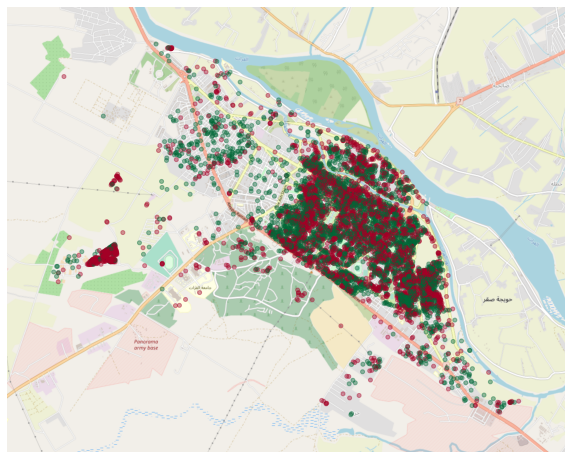

In [25]:
ax = geoplot.webmap(data_ezzor, projection=gcrs.WebMercator(), figsize=(10, 10))
geoplot.pointplot(data_ezzor,
                  ax=ax, 
                  hue='label', 
                  cmap='RdYlGn_r', 
                  s=4, 
                  alpha=0.4,
                  legend=False)
plt.show()

In [31]:
print('Observations sur les batiments :\n Détruits = {}\n Non-détruits = {}'.format(len(data_ezzor[data_ezzor.label==1]),
                                                                                    len(data_ezzor[data_ezzor.label==0])))
print('{}% de nos observations sont labelisées comme détruites.'.format(round(data_ezzor['label'].mean() * 100)))

Observations sur les batiments :
 Détruits = 3531
 Non-détruits = 3110
53% de nos observations sont labelisées comme détruites.


Nous réunissons les coordonées géographiques des bâtiments observées ainsi que le label qui leur est associé dans un même DataFrame que nous sauvegardons dans le dossier *data/process/*.

In [34]:
BASE_DIR_PROCESS = os.path.join(BASE_DIR, 'data/process')
BASE_DIR_PROCESS

'../../data/process'

In [37]:
data_label_ezzor = data_ezzor[['label', 'geometry']]
data_label_ezzor.to_csv(os.path.join(BASE_DIR_PROCESS, 'data_label_ezzor.csv'), index=False)

Suppression des fichiers temporaires

In [40]:
for file in os.listdir(os.path.join(DATA_DIR_RAW, 'temp')):
    os.remove(os.path.join(DATA_DIR_RAW, 'temp', file))
os.rmdir(os.path.join(DATA_DIR_RAW, 'temp'))

-------------------
--------------------

## **Base Alep**

La méthodologie précédente est reproduite pour traiter les données de la ville d'Alep.

### **Importation des données**

In [44]:
zip_file = ZipFile(os.path.join(DATA_DIR_RAW, 'unitar_data/UNOSAT_CE20130604SYR_Syria_Damage_Assessment_2016_shp.zip'))
zip_file.extractall(os.path.join(DATA_DIR_RAW, 'temp'))

data_alep = gpd.read_file(os.path.join(DATA_DIR_RAW, 'temp/6_Damage_Sites_Aleppo_SDA.shp'))
data_alep.head(3)

,SiteID,SensDt,SensorID,ConfID,DmgCls,SensDt_2,SensID_2,ConfID_2,DmgCls_2,DmgSts_2,...,ConfID_4,DmgCls_4,DmgSts_4,GrpDmgCls,FldValid,Notes,StlmtNme,Neighbrhd,EventCode,geometry
0,Building (General / Default),None,None,None,None,2014-05-23,Worldview-2,Very High,Severe Damage,New - damage,...,Very High,Severe Damage,No change,Damaged Buildings,Not yet field validated,None,Aleppo,Rasafeh,CE20130604SYR,POINT (37.13543 36.23547)
1,Building (General / Default),None,None,None,None,2014-05-23,Worldview-2,Very High,Severe Damage,New - damage,...,Very High,Severe Damage,No change,Damaged Buildings,Not yet field validated,None,Aleppo,Rasafeh,CE20130604SYR,POINT (37.13539 36.23557)
2,Building (General / Default),None,None,None,None,2014-05-23,Worldview-2,Very High,Severe Damage,New - damage,...,Very High,Severe Damage,No change,Damaged Buildings,Not yet field validated,None,Aleppo,Rasafeh,CE20130604SYR,POINT (37.13908 36.24100)


In [46]:
data_alep = data_alep[['SiteID','SensDt_4','SensID_4','ConfID_4','DmgCls_4','DmgSts_4',
                     'GrpDmgCls','FldValid','Notes','StlmtNme','Neighbrhd',
                     'EventCode','geometry']]

data_alep['DmgCls_4'].value_counts()

Moderate Damage      16269
Severe Damage        14680
Destroyed             4773
No Visible Damage      214
Name: DmgCls_4, dtype: int64

In [47]:
data_alep['DmgCls_4'] = data_alep['DmgCls_4'].astype('category')
data_alep['DmgCls_4'] = data_alep['DmgCls_4'].cat.set_categories(['No Visible Damage', 'Moderate Damage', 'Destroyed', 'Severe Damage'], ordered=True)


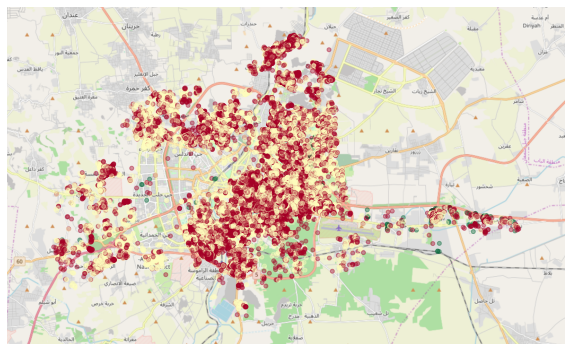

In [49]:
colors = {'Destroyed':1.0, 'Severe Damage':0.66, 'Moderate Damage':0.33, 'No Visible Damage':0.0}

ax = geoplot.webmap(data_alep, projection=gcrs.WebMercator(), figsize=(10, 10))
geoplot.pointplot(data_alep,
                  ax=ax, 
                  hue=data_alep['DmgCls_4'].apply(lambda x : colors[x]), 
                  cmap='RdYlGn_r', 
                  s=4, 
                  alpha=0.4,
                  legend=False)
plt.show()

### **Labellisation des données**

In [51]:
data_alep['label'] = data_alep['DmgCls_4'].apply(labellisation)

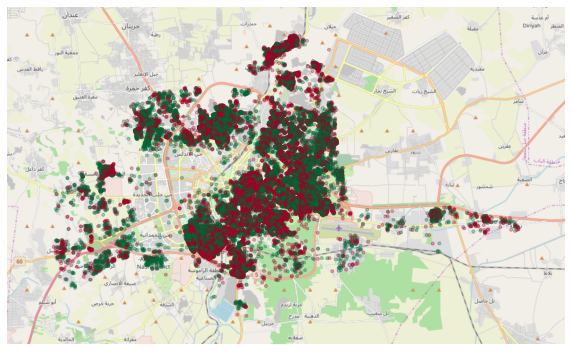

In [54]:
ax = geoplot.webmap(data_alep, projection=gcrs.WebMercator(), figsize=(10, 10))
geoplot.pointplot(data_alep,
                  ax=ax, 
                  hue='label', 
                  cmap='RdYlGn_r', 
                  s=3, 
                  alpha=0.3,
                  legend=False)
plt.show()

In [58]:
print('Observations sur les batiments :\n Détruits = {}\n Non-détruits = {}'.format(len(data_alep[data_alep.label==1]),
                                                                                    len(data_alep[data_alep.label==0])))
print('{}% de nos observations sont labelisées comme détruites.'.format(round(data_alep['label'].mean() * 100)))

Observations sur les batiments :
 Détruits = 19453
 Non-détruits = 16483
54% de nos observations sont labelisées comme détruites.


Nous réunissons les coordonées géographiques des bâtiments observées ainsi que le label qui leur est associé dans un même DataFrame que nous sauvegardons dans le dossier *data/process/*.

In [59]:
data_label_alep = data_alep[['label', 'geometry']]
data_label_alep.to_csv(os.path.join(BASE_DIR_PROCESS, 'data_label_alep.csv'), index=False)

In [60]:
for file in os.listdir(os.path.join(DATA_DIR_RAW, 'temp')):
    os.remove(os.path.join(DATA_DIR_RAW, 'temp', file))
os.rmdir(os.path.join(DATA_DIR_RAW, 'temp'))